In [2]:
import pigpio
import math
from time import sleep
import numpy as np
import matplotlib.pyplot as plt
from moviepy.video.io.bindings import mplfig_to_npimage
from tflite_runtime.interpreter import Interpreter
import cv2

In [3]:
class TLE493D:
    
    """Class of 3D Magnetic Sensor TLE493D.
    """  
    bx = 0
    by = 0
    bz = 0 
    temp = 0
    data =[]

    # Initializing the pigpio libraary
    pi = pigpio.pi()    
    
    # 7-bit I2C address scanned and I2C channel in use by Rpi
    addr = 0x35  
    channel = 1  
    
    # Initializes the I2C handle, used for further communication
    h = pi.i2c_open(channel, addr)

    # Reading the default values of all 23 registers of the sensor.               
    (count, data) = pi.i2c_read_device(h, 23) 

    # If count is 23, that means successful communication, if count is negative one can check the error code of the pigpio  
    print(count,"             ",data)           
    

    def initialize(self): 
        """ Write configuration to the register
        """
        global data
        
        # Enabling One-byte read, Clock Stretching enabled, /INT disabled, Master Controlled Mode 
        self.pi.i2c_write_byte_data(self.h, 0x11, 0x15) 
        # Temp measurement enabled, Bz measurement enabled, ADC trigger on reading after 0x05 register
        self.pi.i2c_write_byte_data(self.h, 0x10, 0x20) 
        sleep(60e-6)                                    
        (count, data) = self.pi.i2c_read_device(self.h, 23)
        print(data) 
        
    def update_data (self):
        """ Read data from register
        """
        global data
        (count, data) = self.pi.i2c_read_device(self.h, 6)

        
    def get_x(self):
        """ Get the value of Bx values of Magnetic field
            
            Returns:
            
            double: Bx values Magnetic field
        """
        
        self.bx = (data[0] << 4) or ((data[4] >> 4) & 0x0f)
        
        if self.bx > 2047:
            
            self.bx -= 4096
        self.bx *=0.098
            
        return self.bx
    
    
    def get_y(self):
        """ Get the value of By values of Magnetic field
            
            Returns:
            
            double: By values of Magnetic field
        """
        self.by = data[1] << 4 or data[4] & 0x0f

        
        if self.by > 2047:
            
            self.by -= 4096
        self.by *=0.098
            
        return self.by

    
    def get_z(self):
        """ Get the value of Bz values of Magnetic field
            
            Returns:
            
            double: Bz values of Magnetic field
        """
        
        self.bz = data[2] << 4 or data[5] & 0x0f
        
        if self.bz > 2047:
            
            self.bz -= 4096
        self.bz *=0.098
            
        return self.bz
    
    
    def get_br(self):
        """ Calculate the radial values of Magnetic field
            
            Returns:
            
            double : radial values of Magnetic field
        """
        
        br = math.sqrt(self.bx*self.bx+self.by*self.by+self.bz*self.bz)
        
        return br
    
    
    def get_polar(self):
        """ Calculate the polar (theta) values of Magnetic field
            
            Returns:
            
            double: polar values of Magnetic field
        """
        
        polar = math.cos(math.atan2(self.bz,math.sqrt(self.bx*self.bx+self.by*self.by)))
        
        return polar
    
    
    def get_azimuth(self):
        """ Calculate the azimuthal (phi) values of Magnetic field
            
            Returns:
            
            double: azimuthal values of Magnetic field
        """
        
        azimuth = math.atan2(self.by,self.bx)
        
        return azimuth
  

23               bytearray(b'\xfb\x0b\x06N\x1b\t\xce\x80\x7f\x80\x7f\x80\x7f888 \x154\x00\xff\xff\xc9')


In [4]:

def set_input_tensor(interpreter, image):

    tensor_index = interpreter.get_input_details()[0]['index']
    input_tensor = interpreter.tensor(tensor_index)()[0]
    input_tensor[:, :] = image

def classify_image(interpreter, image, top_k=1):

    set_input_tensor(interpreter, image)
    interpreter.invoke()
    output_details = interpreter.get_output_details()[0]
    output = np.squeeze(interpreter.get_tensor(output_details['index']))
    return output

def initialize_model():
    # Provide the model_path to tflite Interpreter, to load it
    data_folder = "./"
    model_path = data_folder + "Models/shapemodel.tflite"
    interpreter = Interpreter(model_path)
    print("Model Loaded Successfully.")
    return interpreter

def interpreter(img, interpreter):

    interpreter.allocate_tensors()

    # Preprocessing the image, reshaping the image array to 32x32x1, converting it to float_32
    image = cv2.resize(img, (32,32))
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    gray_image = gray.reshape(32,32,1)
    gray_image.astype(np.float32)
    gray_image = gray_image/255
    gray_image.astype(np.float32)
    output = classify_image(interpreter, gray_image)
    return output

def plot(mat):
    # Image plotter function from the azimuth and polar values of magentic fields.
    fig = plt.figure(figsize=(5,5))
    plt.polar(mat[100:,1], mat[100:,0],linewidth = 7, c = "0")
    plt.grid(False)
    plt.axis("off")
    plt.show()
    
    # to convert matplotlib plot to numpy array
    np_img = mplfig_to_npimage(fig)
    np_img = 255 - np_img
    return np_img

In [21]:
#define the matrix, size=(n,2) to store azimuthal and polar values.
mat = np.zeros((1,2),dtype=np.float64)

# Creating an object of TLE493D class                              
tle = TLE493D()

# Configuring the CONFIG and MOD1 register of the sensor
tle.initialize() 

# Loading the model                                                   
model = initialize_model()

# Dictionary with keys = output class of the model, and values = corresponding String to the output class                                          
pred = {0: "CIRCLE", 1: "WRONG SHAPE", 2: "SQUARE", 3: "TRIANGLE"}  

bytearray(b'\x07\xfa\x02M\x80\xccL\x80\x7f\x80\x7f\x80\x7f888 \x154\x00\xff\xff\xc9')
Model Loaded Successfully.


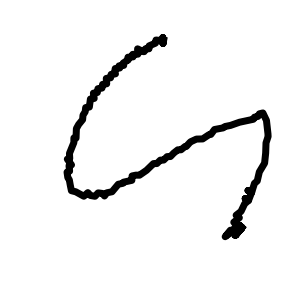

Predicted Output:  WRONG SHAPE


In [19]:

while True:
    # Reading the data from the registers of the TLE493D device an getting Bx, By, Bz, and then calculate polar, and azimuth values of magnetic fields
    tle.update_data()                           
    x = tle.get_x()
    y = tle.get_y()
    z = tle.get_z()
    r = tle.get_br()
    
    theta = tle.get_polar() 
    azi = tle.get_azimuth()
    mat = np.vstack((mat, [theta, azi]))
    
    (mat_r, mat_c) = mat.shape
    sleep (200e-6)

    # Control, to predict shape after accumlating 1000 data points
    if ((mat_r%1000)==0):
        
        # Plotting a polar-plot from the acquired matrix of azimuthal and polar angles                       
        img = plot(mat[mat_r-1000:mat_r, :])
        
        # Predictions on the obtained plot    
        output = interpreter(img, model)        
        print("Predicted Output: ", pred[output.argmax()])
        break